<a href="https://colab.research.google.com/github/Farfaoua01/DL_Project/blob/data-pretraitement/projetdl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img


In [ ]:
data_dir = '/content/drive/MyDrive/brain_tumor_dataset'

categories = ['yes', 'no']
print(os.listdir(data_dir))

['yes', 'no']


# Nouvelle section

In [ ]:
for category in categories:
    path = os.path.join(data_dir, category)
    print(f"{category}: {len(os.listdir(path))} images")


yes: 155 images
no: 98 images


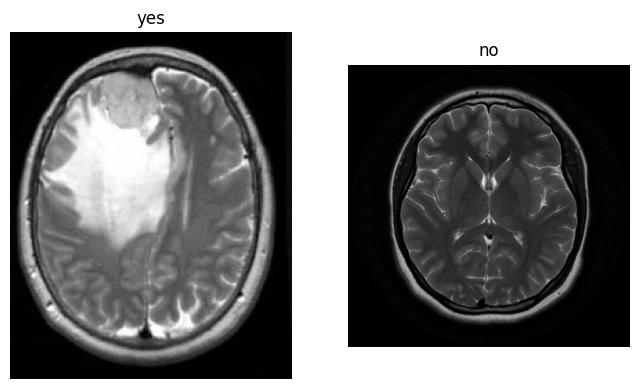

In [ ]:
plt.figure(figsize=(8, 8))
for i, category in enumerate(categories):
    path = os.path.join(data_dir, category)
    img_path = os.path.join(path, os.listdir(path)[0])
    img = load_img(img_path)
    plt.subplot(1, 2, i+1)
    plt.imshow(img)
    plt.title(category)
    plt.axis('off')
plt.show()


In [ ]:
#nettoyage des donnees
corrupted_count = 0

for category in categories:
    path = os.path.join(data_dir, category)
    for img_name in os.listdir(path):
        img_path = os.path.join(path, img_name)
        try:
            img = load_img(img_path)
        except Exception as e:
            print(f"Erreur avec {img_name}: {e}")
            corrupted_count += 1

if corrupted_count == 0:
    print("Toutes les images ont été chargées correctement. Aucun fichier vide ou corrompu trouvé")
else:
    print(f"Nombre d'images corrompues ou illisibles : {corrupted_count}")

Toutes les images ont été chargées correctement. Aucun fichier vide ou corrompu trouvé


{'yes': 155, 'no': 98}


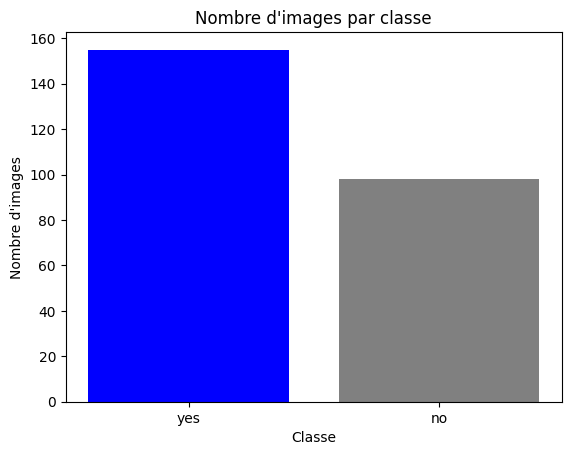

In [ ]:
counts = {}
for category in categories:
    path = os.path.join(data_dir, category)
    counts[category] = len(os.listdir(path))

print(counts)
plt.bar(counts.keys(), counts.values(), color=['blue', 'gray'])
plt.title("Nombre d'images par classe")
plt.xlabel("Classe")
plt.ylabel("Nombre d'images")
plt.show()


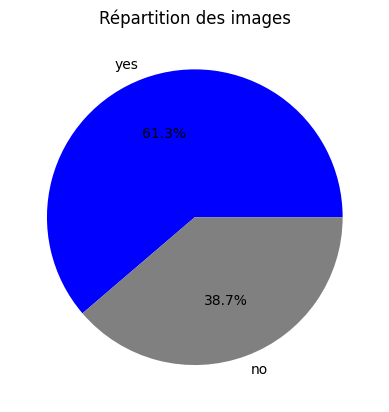

In [ ]:
plt.pie(counts.values(), labels=counts.keys(), autopct='%1.1f%%', colors=['blue', 'gray'])
plt.title("Répartition des images")
plt.show()



In [ ]:
#Augmentation des données pour la classe
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_gen = datagen.flow_from_directory(
    '/content/drive/MyDrive/brain_tumor_dataset',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)


Found 253 images belonging to 2 classes.
